This project involves building and evaluating a deep learning model for fish images classification using the Inception architecture. The project utilizes TensorFlow/Keras for model training and evaluation, focusing on image preprocessing, neural network architecture design, and data management. The development process included the following stages:

**Data Preprocessing**

Images were sorted by class and a fixed number of images per class were selected for consistency. The dataset was then split into training, validation, and test sets. Images were resized, normalized, and converted to numerical arrays to prepare them for model training.

**Model Creation**

An Inception-based Convolutional Neural Network was designed, incorporating various Inception modules and auxiliary classifiers to enhance performance. The auxiliary classifiers were added to improve the model's ability to learn and generalize by providing additional supervision at intermediate layers.  The model was trained on the prepared dataset with mechanisms for validation and early stopping to optimize accuracy.

**Evaluation and Prediction**

After training, the model’s performance was evaluated using the validation set, and predictions were compared with the true labels to assess accuracy. The evaluation included visualizing sample predictions for both the main output and the auxiliary classifiers to verify the model’s effectiveness.

**Results Showcase**

The model’s training and validation metrics, such as loss and accuracy, were plotted. The model was saved for future use, and predictions on test samples were examined. Specifically, main output achieved a prediction accuracy of 76.05%, with detailed metrics on loss and accuracy visualized. The auxiliary classifiers provided additional insights, contributing to the overall performance with accuracies of 79.09% and 80.61%, respectively. Thus this multi-output approach enhanced the model's classification capabilities.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import random
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

def load_and_preprocess_dataset(input_data_dir, output_data_dir, validation_percentage=20, test_percentage=10, image_size=(299, 299), num_images_per_class=750):
    # Get the class names and their counts
    classes = os.listdir(input_data_dir)
    num_classes = len(classes)

    x_data = []
    y_data = []

    for class_idx, class_name in enumerate(classes):
        class_path = os.path.join(input_data_dir, class_name) # Construct the path to the folder for a specific class
        images = os.listdir(class_path) # Get all images in the specified folder
        random.shuffle(images)
        images = images[:num_images_per_class]  # Select a certain number of images for each class

        num_validation_samples = int(len(images) * (validation_percentage / 100.0)) # Calculate the number of images for the validation set
        num_test_samples = int(len(images) * (test_percentage / 100.0))

        for img in images[num_validation_samples + num_test_samples:]:
            img_path = os.path.join(class_path, img)
            image = load_img(img_path, target_size=image_size) # Load the image and resize it
            image = img_to_array(image) # Convert the image to a numerical array
            image = image / 255.0  # Normalize the image to have pixel values in the range [0, 1]
            x_data.append(image)
            y_data.append(class_idx)

    # Convert class labels to one-hot format
    y_data = to_categorical(y_data, num_classes=num_classes)

    # Split the dataset into training, validation, and test sets
    x_train, x_temp, y_train, y_temp = train_test_split(x_data, y_data, test_size=(validation_percentage + test_percentage) / 100.0, random_state=42)
    x_validation, x_test, y_validation, y_test = train_test_split(x_temp, y_temp, test_size=test_percentage / (validation_percentage + test_percentage), random_state=42)

    # Save the processed data
    np.savez_compressed(os.path.join(output_data_dir, 'preprocessed_data.npz'),
                        x_train=x_train, y_train=y_train,
                        x_validation=x_validation, y_validation=y_validation,
                        x_test=x_test, y_test=y_test,
                        classes=classes)

main_data_dir = "/content/drive/MyDrive/fish_classification/fish_dataset"
save_dir = "/content/drive/MyDrive/fish_classification/fish_dataset_preprocessed"

# Ensure the directory exists
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

load_and_preprocess_dataset(main_data_dir, save_dir, validation_percentage=20, test_percentage=10)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 150, 150, 64)         9472      ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 75, 75, 64)           0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 75, 75, 64)           4160      ['max_pooling2d[0][0]']   

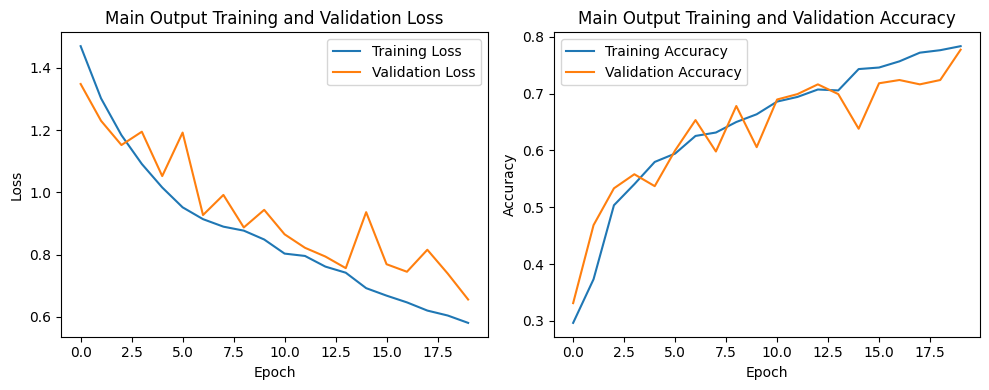

9/9 [==============================] - 5s 284ms/step - loss: 1.8310 - dense_4_loss: 0.6475 - dense_1_loss: 0.5894 - dense_3_loss: 0.5941 - dense_4_accuracy: 0.7605 - dense_1_accuracy: 0.7909 - dense_3_accuracy: 0.8061
Evaluation results: [1.8310190439224243, 0.6475003957748413, 0.5894351601600647, 0.5940833687782288, 0.7604562640190125, 0.7908745408058167, 0.8060836791992188]
loss: 1.8310190439224243
dense_4_loss: 0.6475003957748413
dense_1_loss: 0.5894351601600647
dense_3_loss: 0.5940833687782288
dense_4_accuracy: 0.7604562640190125
dense_1_accuracy: 0.7908745408058167
dense_3_accuracy: 0.8060836791992188


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, GlobalAveragePooling2D, Dense, AveragePooling2D, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

def stem(input_layer):
    conv1 = Conv2D(64, (7, 7), strides=(2, 2), activation='relu', padding='same')(input_layer)
    pool1 = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(conv1)
    conv2 = Conv2D(64, (1, 1), activation='relu', padding='same')(pool1)
    conv3 = Conv2D(192, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(conv3)
    return pool2

def inception_module(prev_layer, filters):
    conv1x1 = Conv2D(filters=filters[0], kernel_size=(1, 1), padding='same', activation='relu')(prev_layer)

    conv3x3 = Conv2D(filters=filters[1], kernel_size=(1, 1), padding='same', activation='relu')(prev_layer)
    conv3x3 = Conv2D(filters=filters[2], kernel_size=(3, 3), padding='same', activation='relu')(conv3x3)

    conv5x5 = Conv2D(filters=filters[3], kernel_size=(1, 1), padding='same', activation='relu')(prev_layer)
    conv5x5 = Conv2D(filters=filters[4], kernel_size=(5, 5), padding='same', activation='relu')(conv5x5)

    pool = MaxPooling2D(pool_size=(3, 3), strides=(1, 1), padding='same')(prev_layer)
    pool = Conv2D(filters=filters[5], kernel_size=(1, 1), padding='same', activation='relu')(pool)

    concat = concatenate([conv1x1, conv3x3, conv5x5, pool], axis=-1)
    return concat

def reduction_module(prev_layer):
    conv3x3 = Conv2D(192, (1, 1), activation='relu', padding='same')(prev_layer)
    conv3x3 = Conv2D(320, (3, 3), strides=(2, 2), activation='relu', padding='valid')(conv3x3)

    conv7x7_1 = Conv2D(192, (1, 1), activation='relu', padding='same')(prev_layer)
    conv7x7_2 = Conv2D(192, (7, 1), activation='relu', padding='same')(conv7x7_1)
    conv7x7_3 = Conv2D(192, (1, 7), activation='relu', padding='same')(conv7x7_2)
    conv7x7_4 = Conv2D(192, (3, 3), strides=(2, 2), activation='relu', padding='valid')(conv7x7_3)

    pool = MaxPooling2D((3, 3), strides=(2, 2), padding='valid')(prev_layer)

    concat = concatenate([conv3x3, conv7x7_4, pool], axis=-1)
    return concat

def auxiliary_classifier(prev_layer, num_classes):
    avg_pool = AveragePooling2D(pool_size=(5, 5), strides=(3, 3))(prev_layer)
    conv1 = Conv2D(128, (1, 1), activation='relu', padding='same')(avg_pool)
    flat = Flatten()(conv1)
    dense1 = Dense(1024, activation='relu')(flat)
    dropout = Dropout(0.7)(dense1)
    output_layer = Dense(num_classes, activation='softmax')(dropout)
    return output_layer

def inception_model(input_shape=(299, 299, 3), num_classes=5):
    input_layer = Input(shape=input_shape)
    stem_output = stem(input_layer)

    inception3a = inception_module(stem_output, [64, 96, 128, 16, 32, 32])
    inception3b = inception_module(inception3a, [128, 128, 192, 32, 96, 64])
    reduction_a = reduction_module(inception3b)

    inception4a = inception_module(reduction_a, [192, 96, 208, 16, 48, 64])
    inception4b = inception_module(inception4a, [160, 112, 224, 24, 64, 64])
    inception4c = inception_module(inception4b, [128, 128, 256, 24, 64, 64])
    inception4d = inception_module(inception4c, [112, 144, 288, 32, 64, 64])
    inception4e = inception_module(inception4d, [256, 160, 320, 32, 128, 128])
    reduction_b = reduction_module(inception4e)

    inception5a = inception_module(reduction_b, [256, 160, 320, 32, 128, 128])
    inception5b = inception_module(inception5a, [384, 192, 384, 48, 128, 128])

    auxiliary_output_1 = auxiliary_classifier(inception4a, num_classes)
    auxiliary_output_2 = auxiliary_classifier(inception4d, num_classes)

    avg_pool = GlobalAveragePooling2D()(inception5b)
    main_output = Dense(num_classes, activation='softmax')(avg_pool)

    model = Model(inputs=input_layer, outputs=[main_output, auxiliary_output_1, auxiliary_output_2])
    return model

# Load data
save_dir = "/content/drive/MyDrive/fish_classification/fish_dataset_preprocessed"
preprocessed_data = np.load(os.path.join(save_dir, 'preprocessed_data.npz'))
x_train = preprocessed_data['x_train']
y_train = preprocessed_data['y_train']
x_validation = preprocessed_data['x_validation']
y_validation = preprocessed_data['y_validation']
x_test = preprocessed_data['x_test']
y_test = preprocessed_data['y_test']
class_labels = preprocessed_data['classes']

# Create model
model = inception_model(num_classes=len(class_labels))

# Compile model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

# Train model
history = model.fit(
    x_train, y_train,
    validation_data=(x_validation, y_validation),
    epochs=20,
    batch_size=8
)

# Plot metrics for the main output
def plot_main_output_metrics(history):
    main_output_loss_key = [key for key in history.history.keys() if 'dense_' in key and 'loss' in key][0]
    main_output_acc_key = [key for key in history.history.keys() if 'dense_' in key and 'accuracy' in key][0]
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history[main_output_loss_key], label='Training Loss')
    if f'val_{main_output_loss_key}' in history.history:
        plt.plot(history.history[f'val_{main_output_loss_key}'], label='Validation Loss')
    plt.title('Main Output Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history[main_output_acc_key], label='Training Accuracy')
    if f'val_{main_output_acc_key}' in history.history:
        plt.plot(history.history[f'val_{main_output_acc_key}'], label='Validation Accuracy')
    plt.title('Main Output Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_main_output_metrics(history)

# Evaluate the model on the test dataset
evaluation_results = model.evaluate(np.array(x_test), np.array(y_test))
print("Evaluation results:", evaluation_results)

# Print individual loss and accuracy values
for i, metric_name in enumerate(model.metrics_names):
    print(f"{metric_name}: {evaluation_results[i]}")

# Display the architecture of the neural network
plot_model(model, "/content/drive/MyDrive/fish_classification/model.png", show_shapes=True)

# Save model
model.save("/content/drive/MyDrive/fish_classification/fish_classification_model.keras")


9/9 [==============================] - 1s 94ms/step


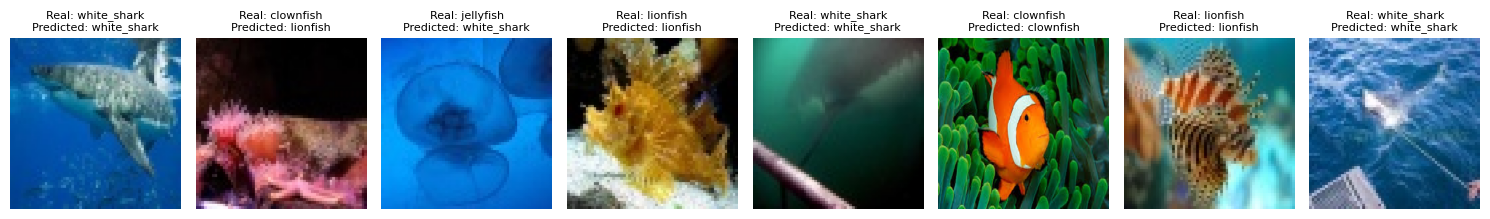

In [ ]:
# main output
import tensorflow as tf
import os
import numpy as np
import random
import matplotlib.pyplot as plt

# Load model
model = tf.keras.models.load_model("/content/drive/MyDrive/fish_classification/fish_classification_model.keras")

# Load data
save_dir = "/content/drive/MyDrive/fish_classification/fish_dataset_preprocessed"
preprocessed_data = np.load(os.path.join(save_dir, 'preprocessed_data.npz'))
x_test = preprocessed_data['x_test']
y_test = preprocessed_data['y_test']
class_labels = preprocessed_data['classes']

# Make predictions and display results
def make_predictions_and_display(model, x_test, y_test, num_samples_to_display, class_labels):
    predictions = model.predict(np.array(x_test))
    main_predictions = predictions[0]  # The main output is the first one

    num_samples = len(x_test)

    plt.figure(figsize=(15, 3))

    sample_indices = random.sample(range(num_samples), num_samples_to_display)

    for i, idx in enumerate(sample_indices):
        plt.subplot(1, num_samples_to_display, i + 1)
        plt.imshow(x_test[idx])

        true_class_index = np.argmax(y_test[idx])  # Get the index of the true label
        main_predicted_class = class_labels[np.argmax(main_predictions[idx])] # Get the predicted class

        plt.title(f"Real: {class_labels[true_class_index]}\nPredicted: {main_predicted_class}", fontsize=8)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

make_predictions_and_display(model, x_test, y_test, num_samples_to_display=8, class_labels=class_labels)


9/9 [==============================] - 2s 95ms/step


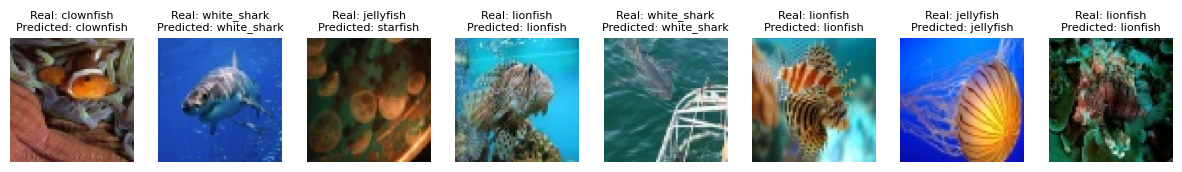

In [ ]:
# main + auxiliary classifier outputs
import tensorflow as tf
import os
import numpy as np
import random
import matplotlib.pyplot as plt

# Load model
model = tf.keras.models.load_model("/content/drive/MyDrive/fish_classification/fish_classification_model.keras")

# Load data
save_dir = "/content/drive/MyDrive/fish_classification/fish_dataset_preprocessed"
preprocessed_data = np.load(os.path.join(save_dir, 'preprocessed_data.npz'))
x_test = preprocessed_data['x_test']
y_test = preprocessed_data['y_test']
class_labels = preprocessed_data['classes']

# Make predictions and display results
def make_predictions_and_display(model, x_test, y_test, num_samples_to_display, class_labels):
    predictions = model.predict(np.array(x_test))

    num_samples = len(x_test)

    plt.figure(figsize=(15, 3))

    sample_indices = random.sample(range(num_samples), num_samples_to_display)

    for i, idx in enumerate(sample_indices):
        plt.subplot(1, num_samples_to_display, i + 1)
        plt.imshow(x_test[idx])

        true_class_index = np.argmax(y_test[idx])

        all_predicted_classes = []
        # Compute the predicted class for each auxiliary classifier
        for set_idx, pred_set in enumerate(predictions):
            predicted_class_index = np.argmax(pred_set[idx])  # Determine the most likely class
            predicted_class = class_labels[predicted_class_index]  # Get the predicted class
            all_predicted_classes.append(predicted_class)

            plt.title(f"Real: {class_labels[true_class_index]}\nPredicted: {predicted_class}", fontsize=8)
            plt.axis('off')

    plt.show()

make_predictions_and_display(model, x_test, y_test, num_samples_to_display=8, class_labels=class_labels)